In [2]:
%matplotlib inline
import numpy as np
from get_EO_analysis_results import get_EO_analysis_results
from get_EO_analysis_files import get_EO_analysis_files
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import scipy.stats as stats
import traceback
import glob
import re
import os
import subprocess
from matplotlib.pyplot import cm

from astropy.table import Table
import pylab
import numpy

raft_types = {}
raft_types['e2v'] = 'R11 R12 R13 R14 R21 R22 R23 R24 R30 R31 R32 R33 R34'.split()
raft_types['ITL'] = 'R01 R02 R03 R10 R20 R41 R42 R43'.split()
raft_types['Corner'] = 'R00 R04 R40 R44'.split()

In [3]:
def getEOresult( run ):
    EO = get_EO_analysis_results(db='Prod')

    dev_list, data = EO.get_tests(site_type='I&T-BOT', run=run)
    return EO.get_all_results(data)

def getsequencer( run ):
    result = {}
    for atype in ["e2v","ITL"]:
        afile = glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{run}/BOT_acq/v0/*/FP_{atype.upper()}_*.seq")[0]
        result[atype] = {}
        with open(afile) as f:
            for aline in f.readlines():
                for akey in ["RampTime", "ISO1", "ISO2"]:
                    try:
                        result[atype].update( {akey: (int(re.search(fr"{akey}:\s*(\d*) ns",aline).groups(1)[0])) } )

                        
                    except:
                        pass
        result[atype]["seqname"] = os.path.basename(afile)

        tmp = (subprocess.run(f"ssh lsst-dc01 /lsst/ccs/prod/bin/seqinfo {afile} | tail -40 | grep ReadFrame",
                             capture_output=True, shell=True).stdout)
        result[atype]["ReadFrameTime"] = int(re.split("[\t\s]+", tmp.decode())[3].replace(",",""))
        
    return result
                    


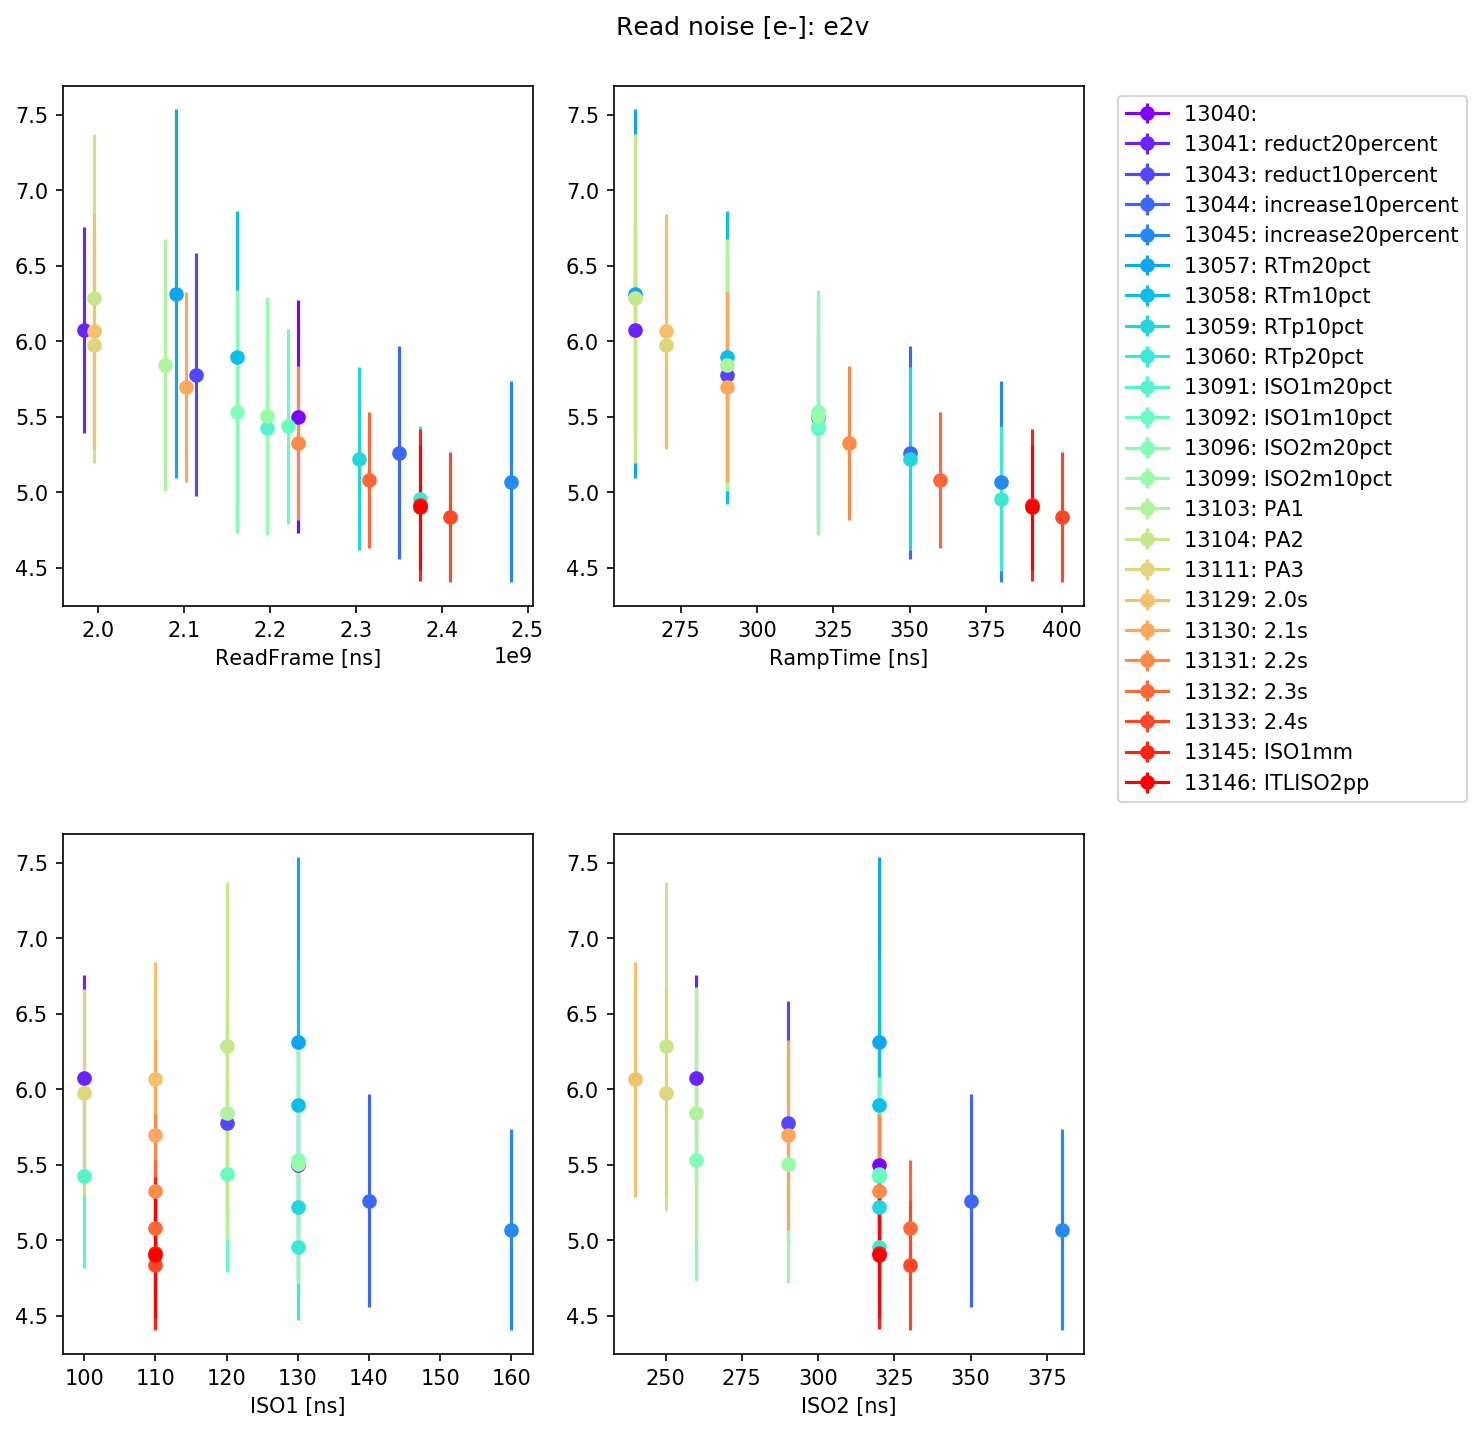

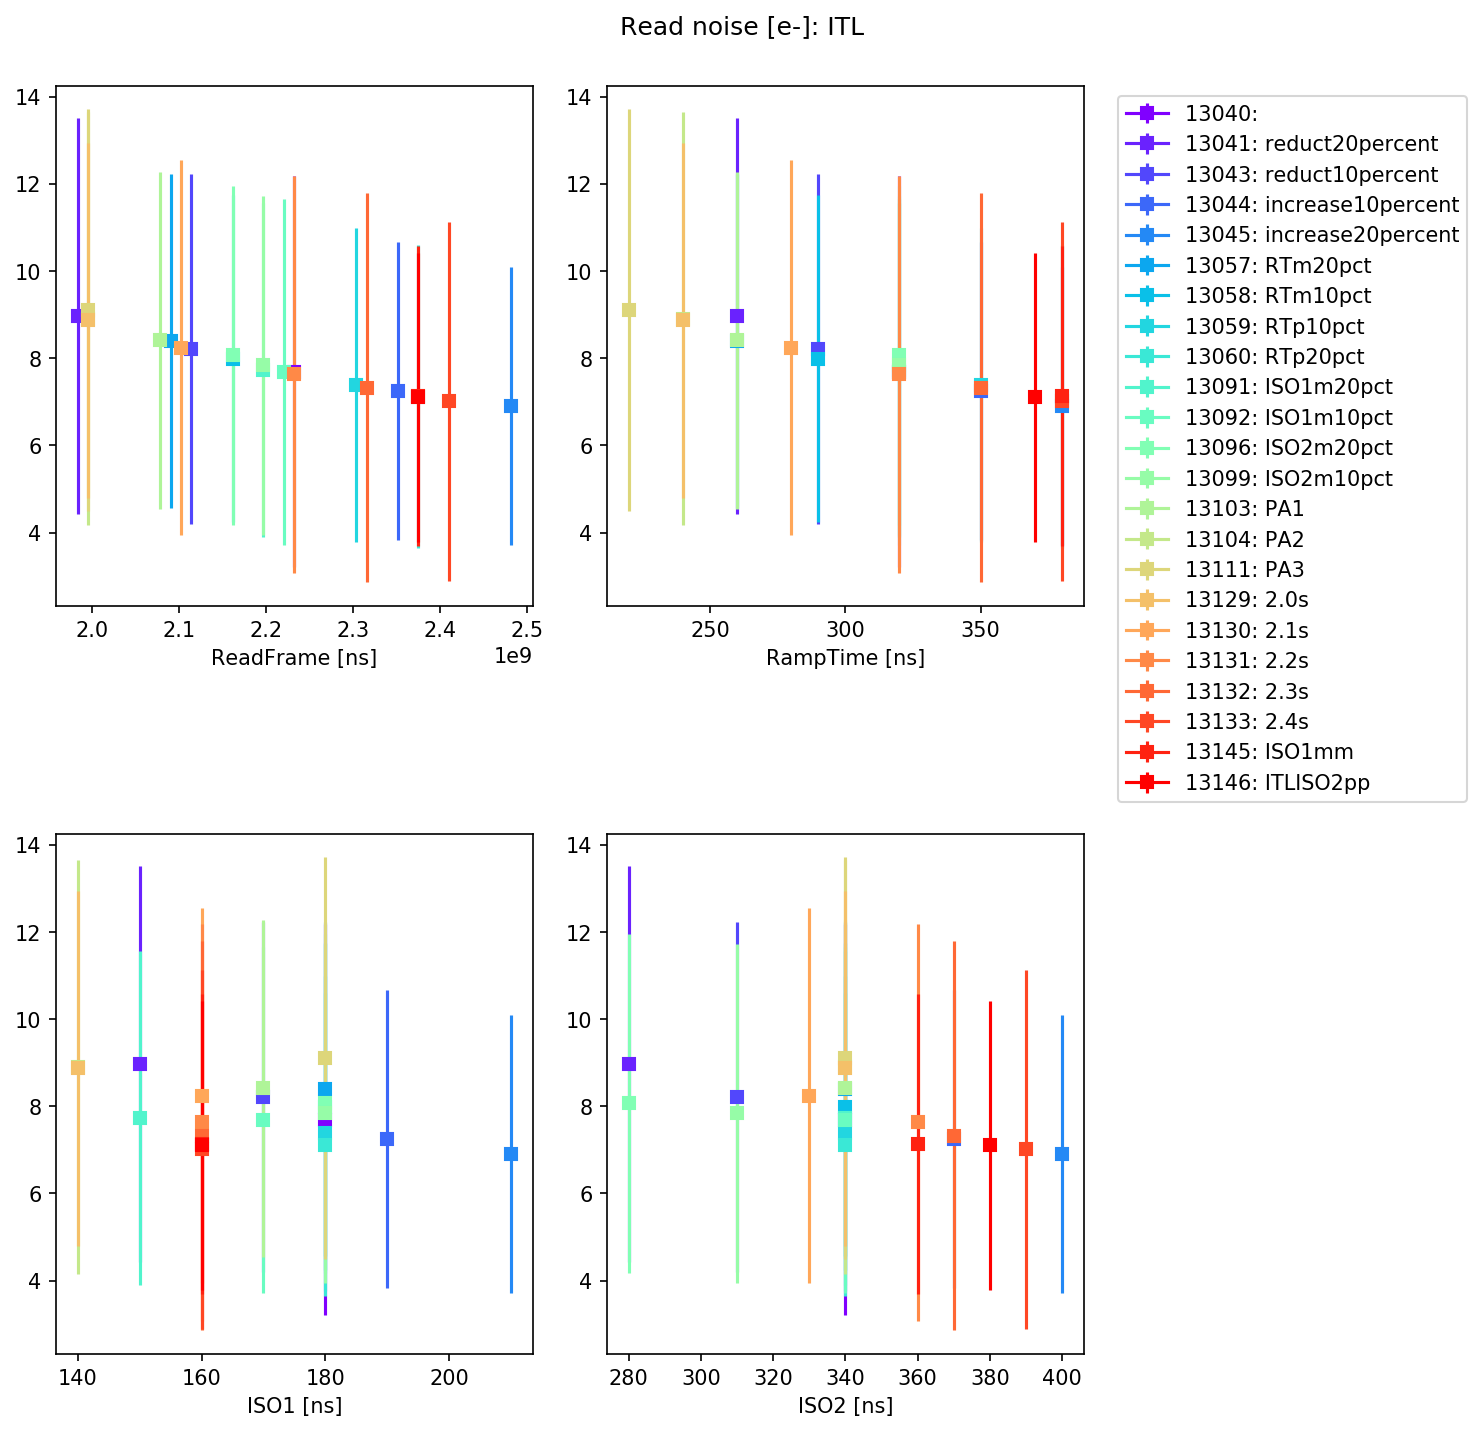

In [4]:
figa, ax = pylab.subplots(2, 2, figsize=(10,10), facecolor="white",dpi=150)
figb, bx = pylab.subplots(2, 2, figsize=(10,10), facecolor="white",dpi=150)

baseline=None

runs = [
    13040, # (baseline)
    # Changing RampTime, ISO1 and ISO2
    13041, # (-20%)
    13043, # (-10%)
    13044, # (+10%)
    13045, # (+20%)
    # Changing RampTime
    13057, # (-20%)
    13058, # (-10%)
    13059, # (+10%)
    13060, # (+20%)
    # Changing ISO1 per @antilogus's request
    13091, # (-20%)
    13092, # (-10%)
    # Changing ISO2 per @antilogus's request
    13096, # (-20%)
    13099, # (-10%)
    # Changing ISO1, ISO2 and RampTime differently
    13103, # (PA1)
    13104, # (PA2)
    13111, # (PA3)    
    # Pierre's variants
    13129, # 2.0
    13130, # 2.1
    13131, # 2.2
    13132, # 2.3
    13133, # 2.4,
    # 
    13145, # ISO1mm
    13146, # ITLISO2pp
    ]

colors = cm.rainbow(numpy.linspace(0, 1, len(runs)))

for color, arun in zip(colors,runs):
    ret = getEOresult(arun)["read_noise"]
    seqinfo = getsequencer(arun)    
    if baseline is None:
        baseline=seqinfo
    pltfmt=None
    for atype in raft_types:
        noise = []

        for abay in raft_types[atype]:
            try:
                t=seqinfo[atype]["ReadFrameTime"]
                noise = numpy.concatenate(
                    [ noise, numpy.array([ ret[abay][asensor] for asensor in ret[abay] ]).flatten() ]
                )
            except:
                pass
        try:
            y=noise*baseline[atype]["RampTime"]/seqinfo[atype]["RampTime"]
            y=y[numpy.where(y>0)]
            mean=numpy.mean(y)
            std=numpy.std(y)
            label=f"{arun}: "+seqinfo["e2v"]["seqname"].replace(baseline["e2v"]["seqname"].replace(".seq",""),"").replace(".seq","")[1:]

            if atype=="e2v":
                marker="o"
                plotters = ax
            else:
                marker="s"
                plotters = bx
            for aplotter, x in zip(plotters.flatten(), [t,
                                         seqinfo[atype]["RampTime"],
                                         seqinfo[atype]["ISO1"],
                                         seqinfo[atype]["ISO2"]
                                        ] ):
                aplotter.errorbar(x, mean, std, marker=marker, color=color, label=label)
                
        except:
            pass
seqinfo = getsequencer(arun)

for figp, px, avendor in [ (figa, ax, "e2v"), (figb, bx, "ITL") ]:
    px[0][0].set_xlabel("ReadFrame [ns]")
    px[0][1].set_xlabel("RampTime [ns]")
    px[1][0].set_xlabel("ISO1 [ns]")
    px[1][1].set_xlabel("ISO2 [ns]")
    px[0][1].legend(bbox_to_anchor=(1.05, 1.0))
    figp.suptitle(f"Read noise [e-]: {avendor}")
    figp.tight_layout(rect=[0, 0.03, 1, 0.95])

13040:  e2v 10294.901448726654
13040:  ITL 8859.8894906044
13040:  Corner 2226.1249685287476
13060: RTp20pct e2v 9279.791207564504
13060: RTp20pct ITL 8201.103571038497
13060: RTp20pct Corner 2251.906633879009
13145: ISO1mm e2v 9196.724604288738
13145: ISO1mm ITL 8211.06788474635
13145: ISO1mm Corner 2311.3301961798416
13146: ITLISO2pp e2v 9170.775771312223
13146: ITLISO2pp ITL 8179.9267574001005
13146: ITLISO2pp Corner 2332.0294379156994


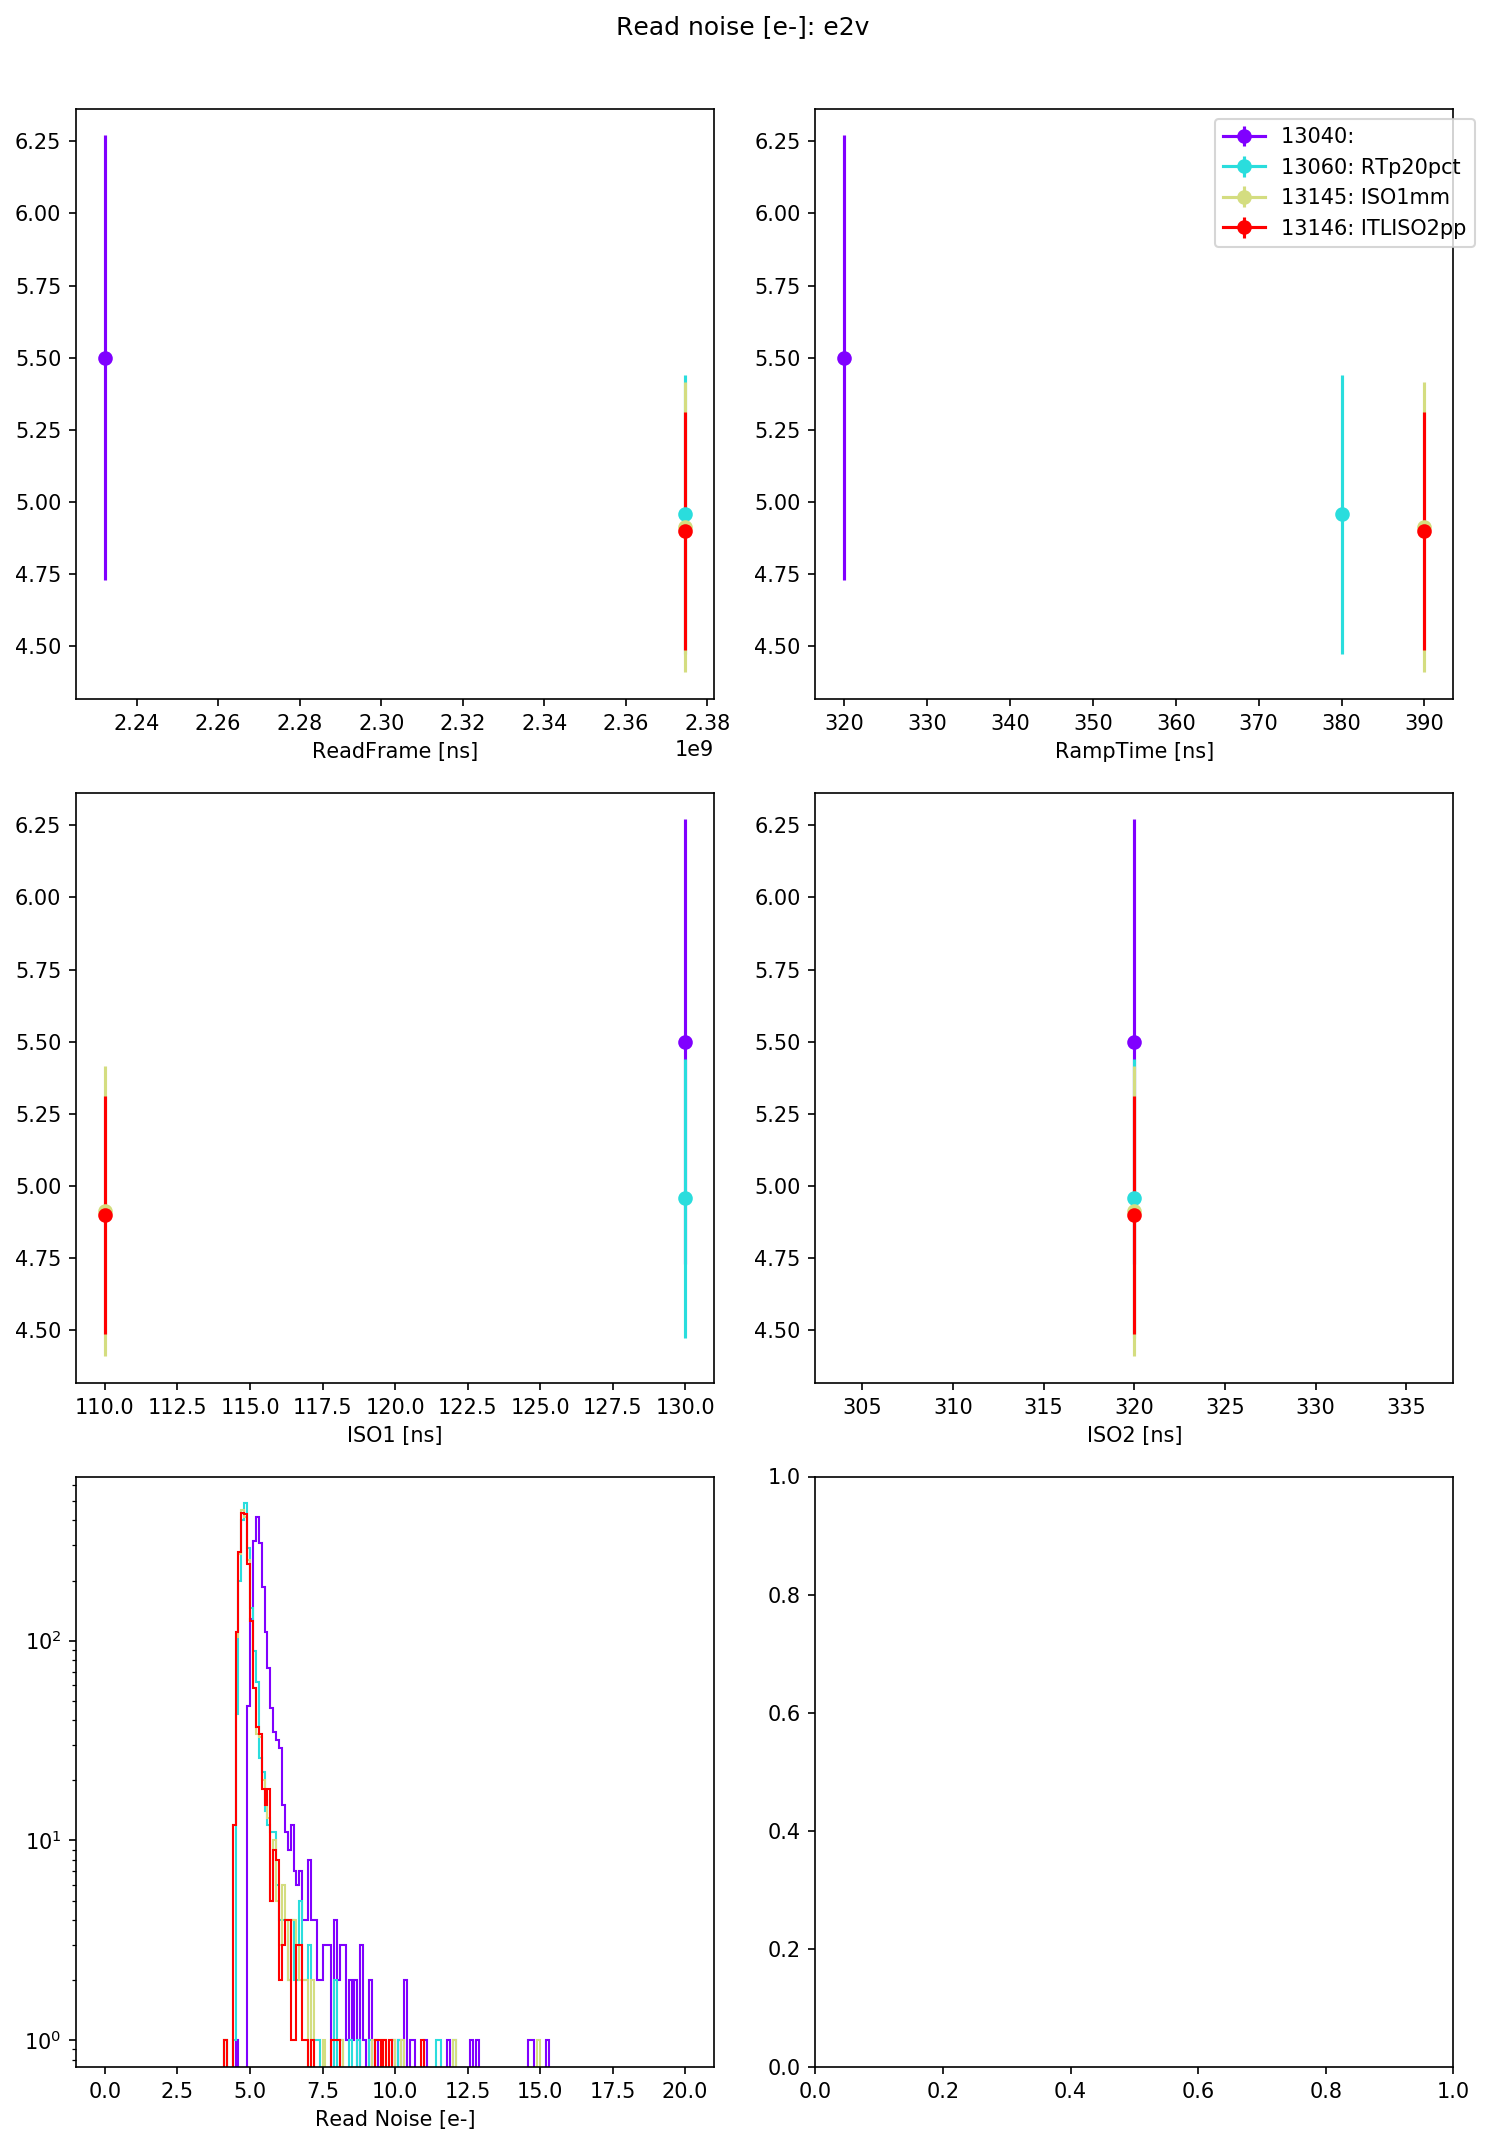

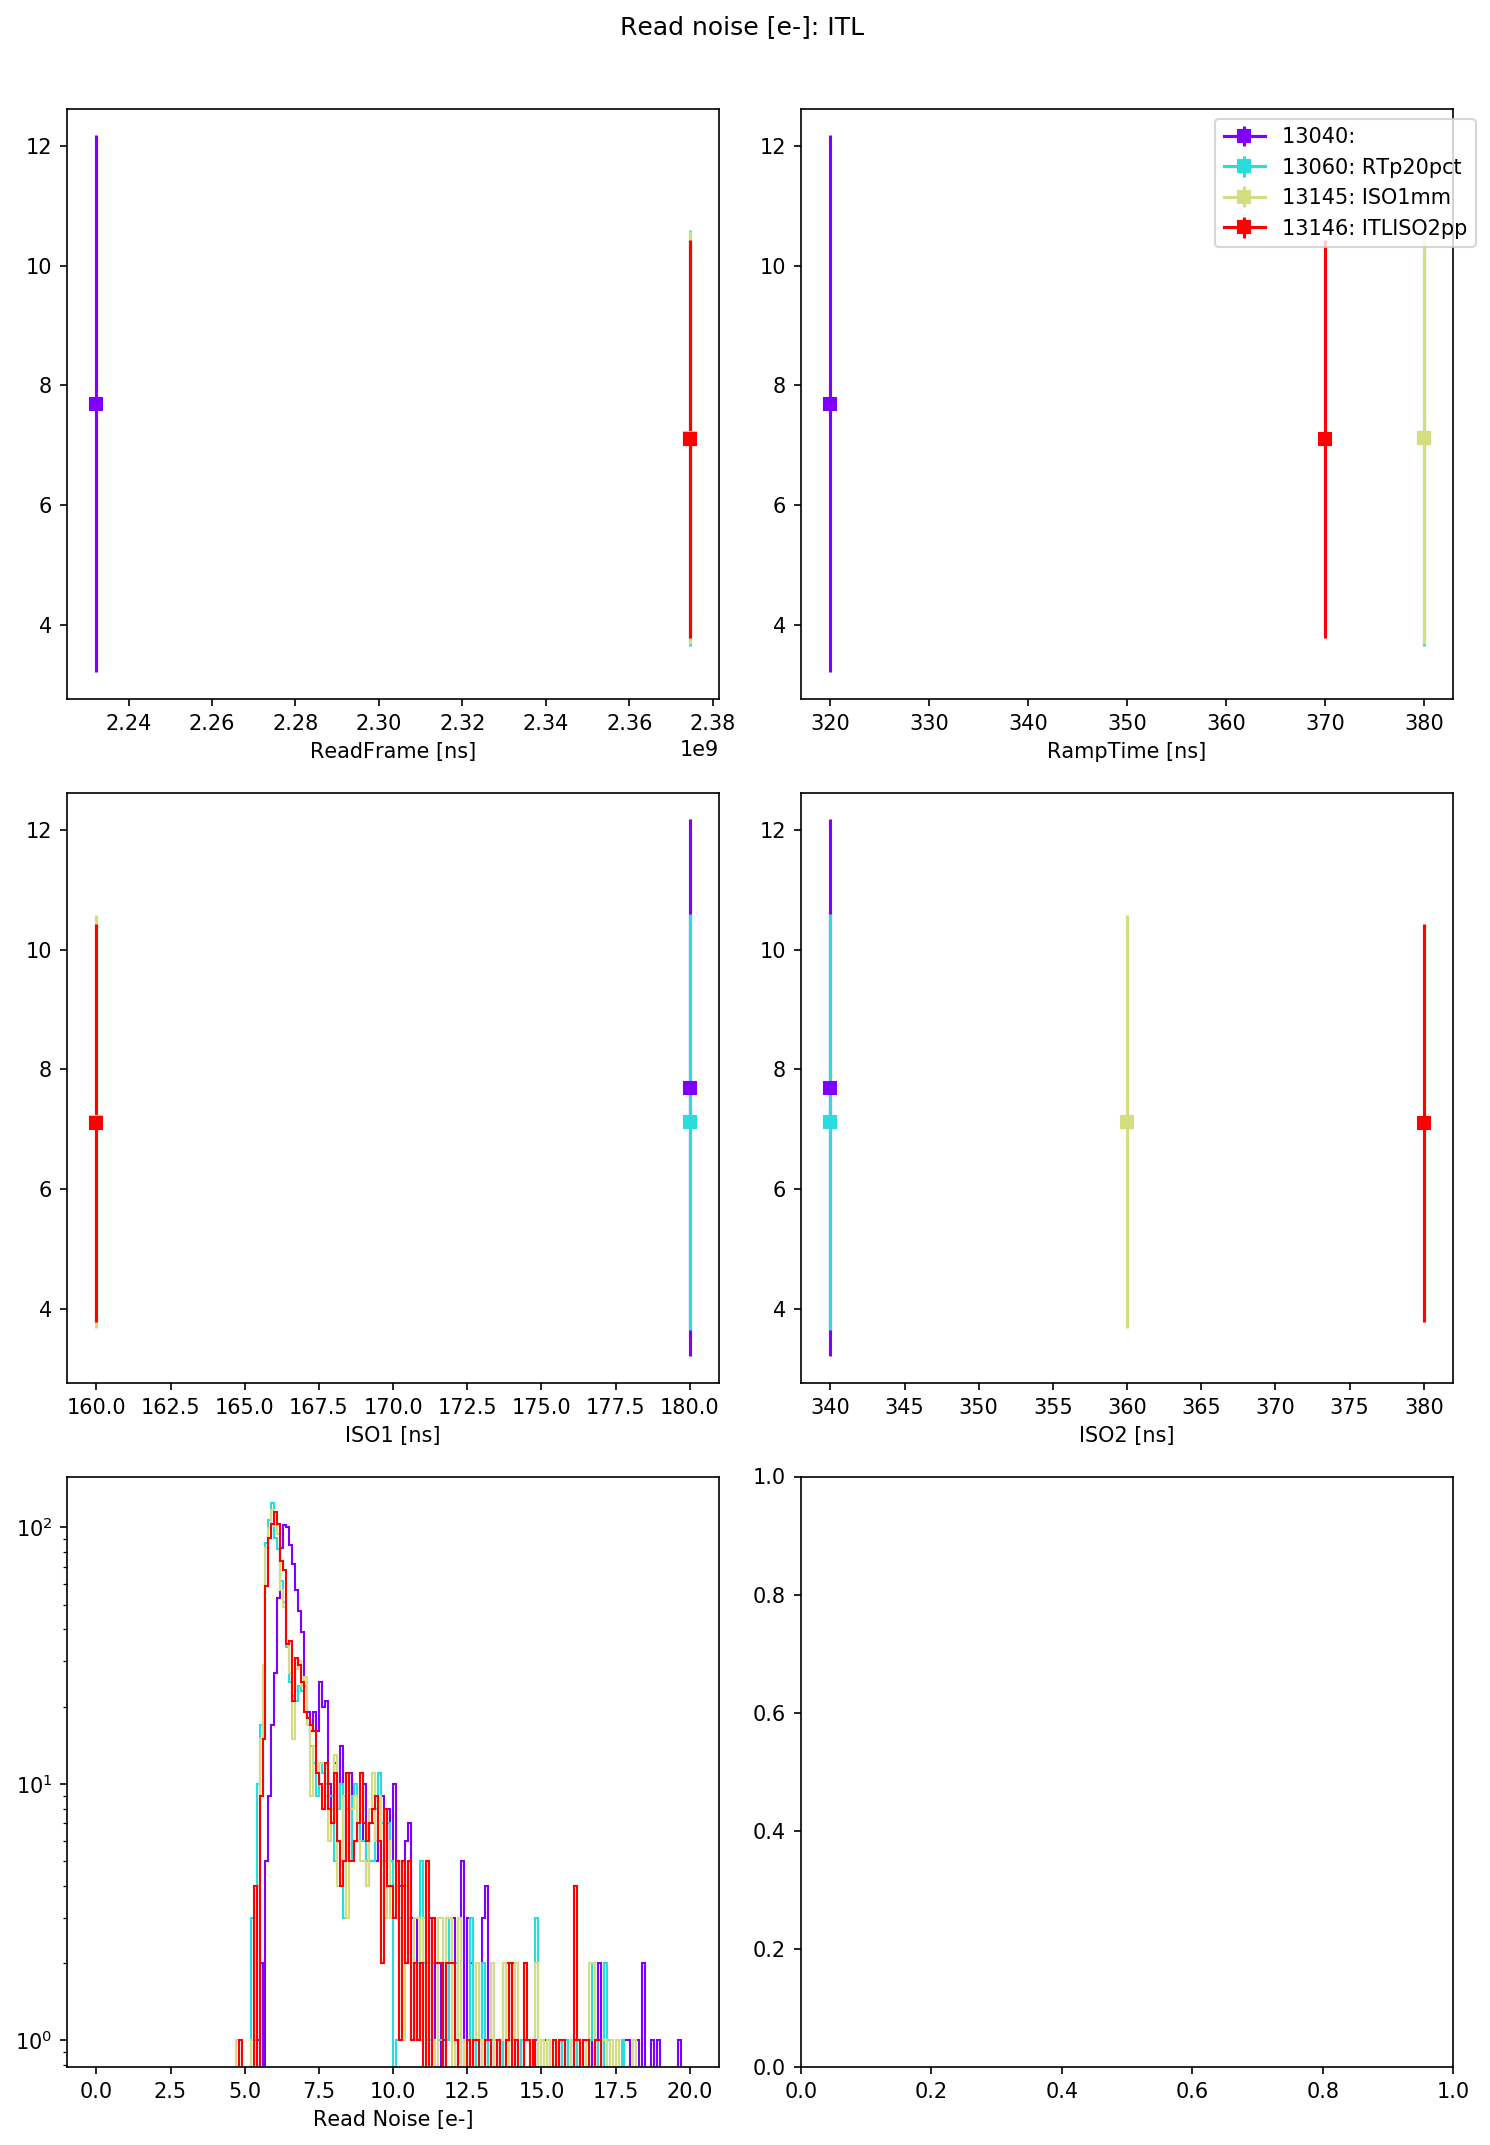

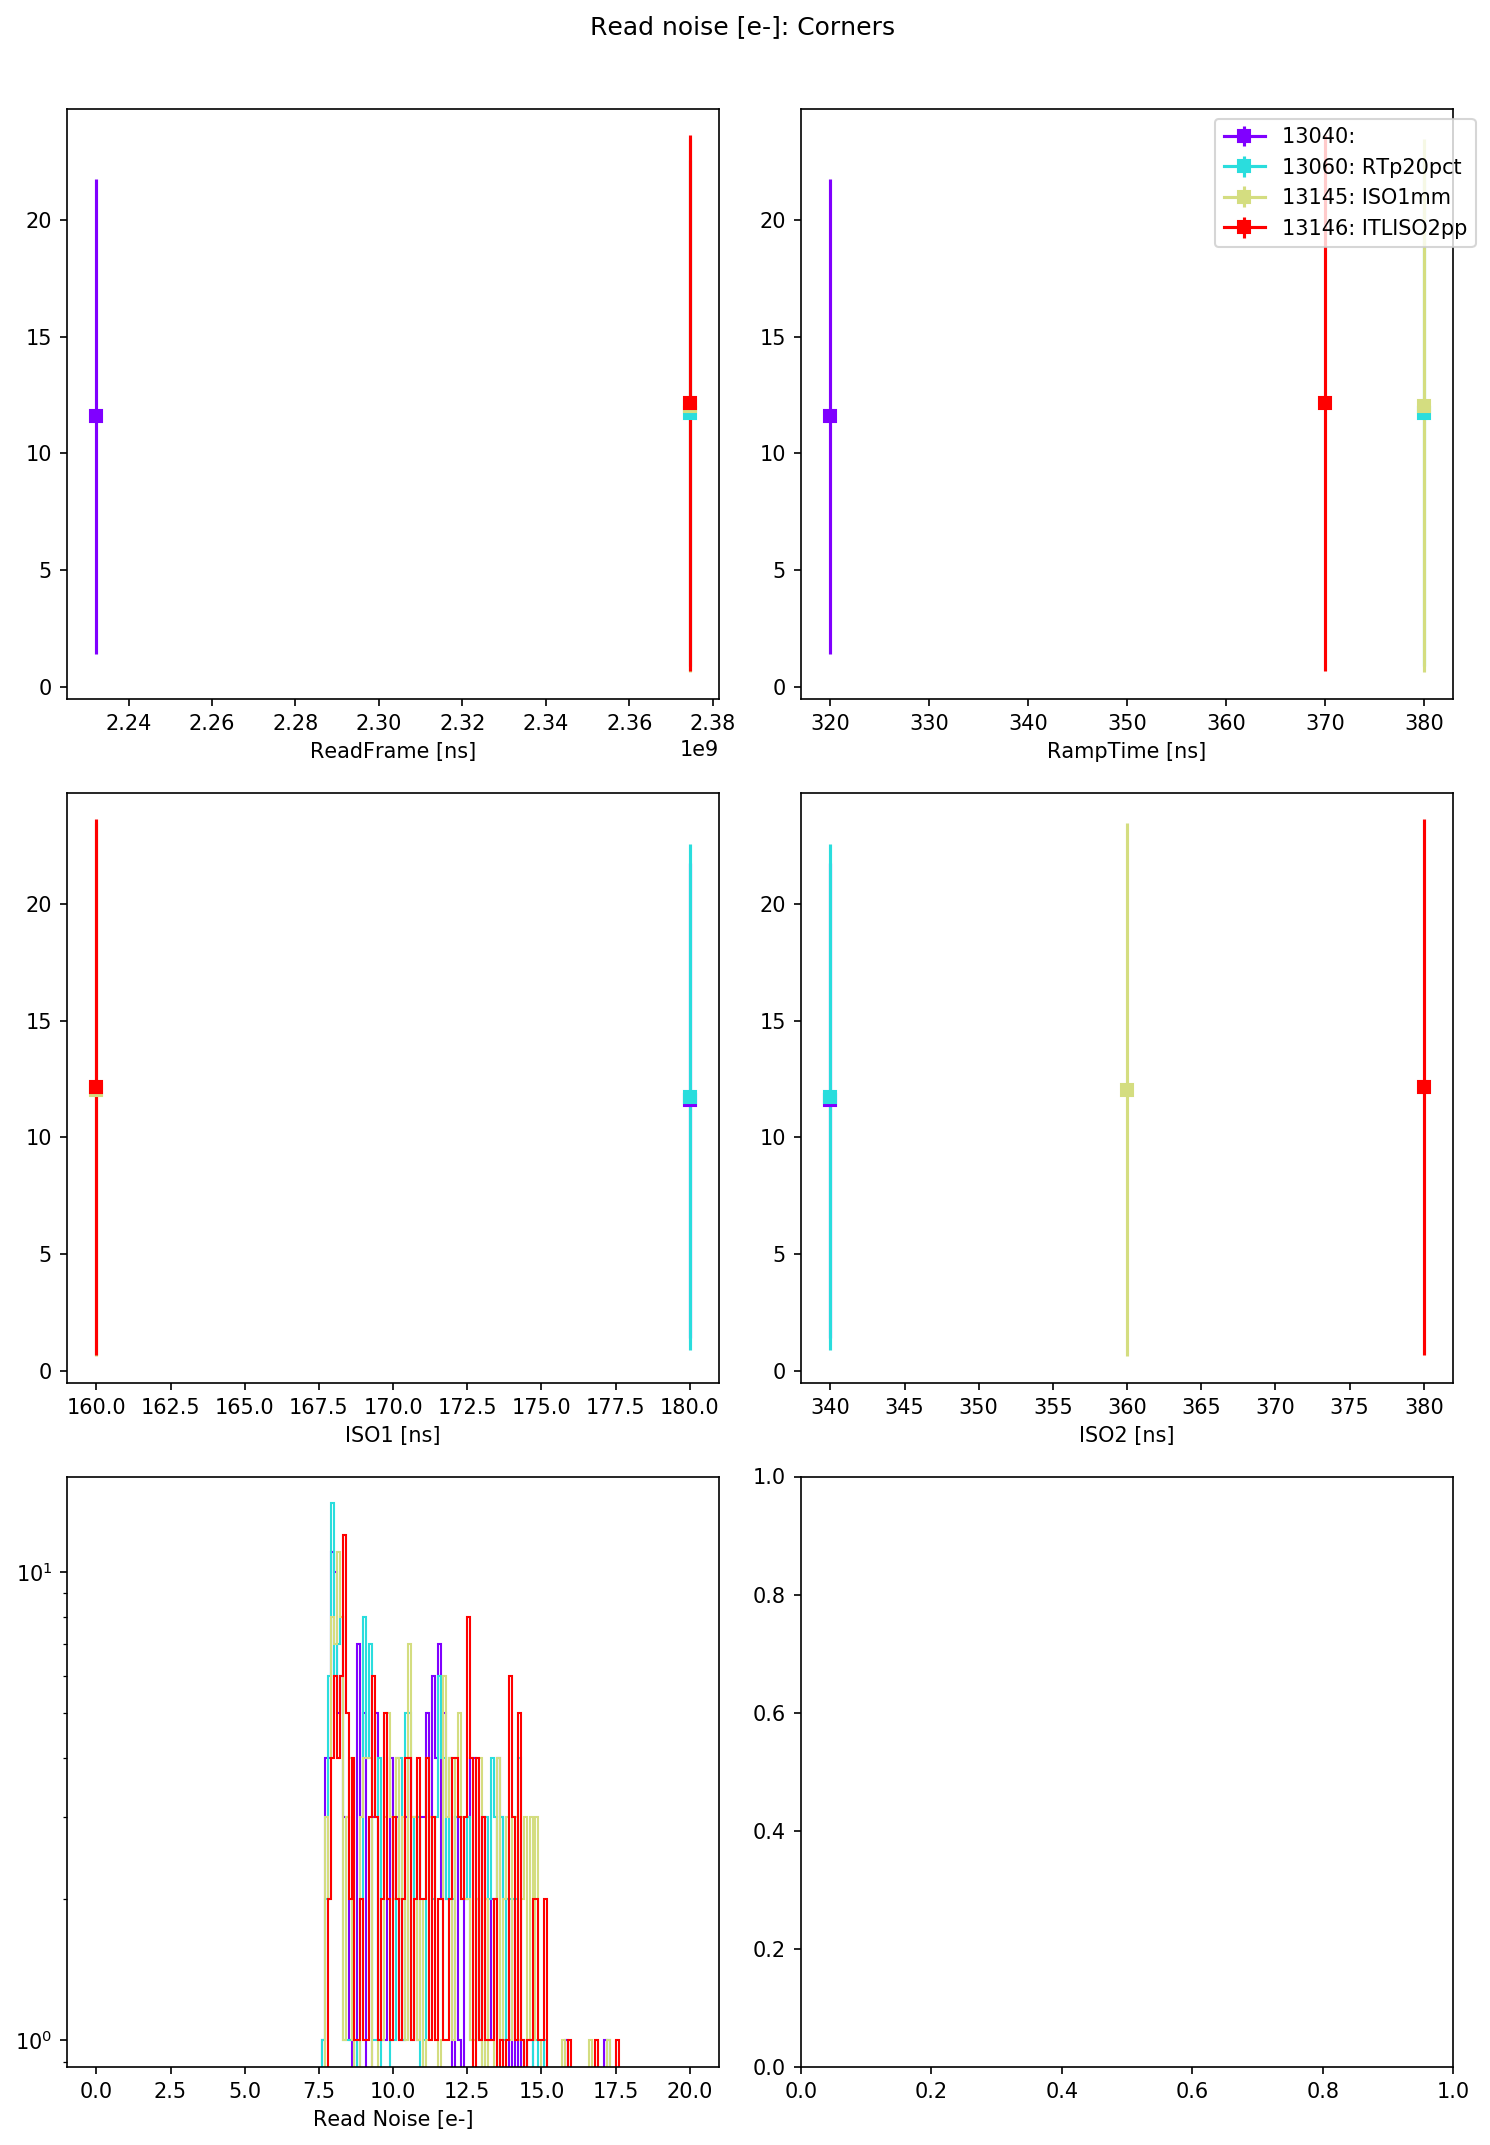

In [25]:
figa, ax = pylab.subplots(3, 2, figsize=(10,15), facecolor="white",dpi=150)
figb, bx = pylab.subplots(3, 2, figsize=(10,15), facecolor="white",dpi=150)
figc, cx = pylab.subplots(3, 2, figsize=(10,15), facecolor="white",dpi=150)


baseline=None

runs = [
    13040, # (baseline)
#    13045, # (+20%)
    13060, # (+20%)    
    13145, # ISO1mm
    13146, # ITLISO2pp
    ]

colors = cm.rainbow(numpy.linspace(0, 1, len(runs)))

for color, arun in zip(colors,runs):
    ret = getEOresult(arun)["read_noise"]
    seqinfo = getsequencer(arun)    
    if baseline is None:
        baseline=seqinfo
    pltfmt=None
    for atype in raft_types:
        noise = []

        for abay in raft_types[atype]:
            try:
                if atype=="e2v":
                    vendor="e2v"
                else:
                    vendor="ITL"                    
                t=seqinfo[vendor]["ReadFrameTime"]
                noise = numpy.concatenate(
                    [ noise, numpy.array([ ret[abay][asensor] for asensor in ret[abay] ]).flatten() ]
                )
            except:
                pass
        try:
            scaling = baseline[vendor]["RampTime"]/seqinfo[vendor]["RampTime"]
            y=noise*scaling
            y=y[y>0]
            mean=numpy.mean(y)
            std=numpy.std(y)
            label=f"{arun}: "+seqinfo["e2v"]["seqname"].replace(baseline["e2v"]["seqname"].replace(".seq",""),"").replace(".seq","")[1:]
#            print(label, atype, scaling)

            if atype=="e2v":
                marker="o"
                plotters = ax
            elif atype=="ITL":
                marker="s"
                plotters = bx
            else:
                marker="s"
                plotters = cx
            for aplotter, x in zip(plotters.flatten(), [t,
                                         seqinfo[vendor]["RampTime"],
                                         seqinfo[vendor]["ISO1"],
                                         seqinfo[vendor]["ISO2"],
                                         None
                                        ] ):
                if x is not None:
                    aplotter.errorbar(x, mean, std, marker=marker, color=color, label=label)
                else:
                    aplotter.hist(y, range=(0,20), bins=200, color=color, label=label, histtype="step")
                    print(label, atype, y.sum())
                
        except:
            raise
seqinfo = getsequencer(arun)

for figp, px, avendor in [ (figa, ax, "e2v"), (figb, bx, "ITL"), (figc, cx, "Corners") ]:
    px[0][0].set_xlabel("ReadFrame [ns]")
    px[0][1].set_xlabel("RampTime [ns]")
    px[1][0].set_xlabel("ISO1 [ns]")
    px[1][1].set_xlabel("ISO2 [ns]")
    px[2][0].semilogy()
    px[2][0].set_xlabel("Read Noise [e-]")
    px[0][1].legend(bbox_to_anchor=(1.05, 1.0))
    figp.suptitle(f"Read noise [e-]: {avendor}")
    figp.tight_layout(rect=[0, 0.03, 1, 0.95])